# Ejercicio 05

In [48]:
import numpy as np

In [49]:
import matplotlib.pyplot as plt

In [50]:
import math

## Lectura de la imagen original

In [51]:
from skimage.io import imread

In [52]:
from skimage.io import imsave

In [53]:
original_image = imread('../resources/mono.bmp')

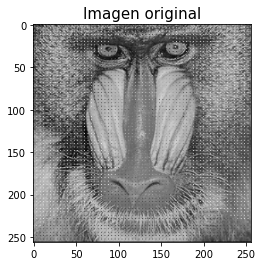

In [54]:
plt.imshow(original_image, cmap='gray')
plt.title('Imagen original', fontsize=15)
plt.show()

In [55]:
print(f'El tamaño original es {original_image.shape}')

El tamaño original es (256, 256)


## Espectro de la imagen original
Se calcula la transformada rápida de fourier en dos dimensiones para la imagen original.

In [56]:
spectrum_original = np.fft.fftshift(np.fft.fft2(original_image, s=(256, 256)))

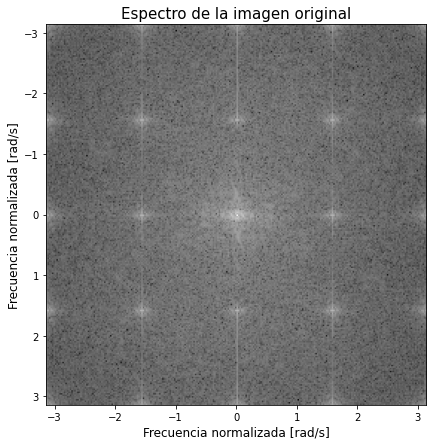

In [57]:
plt.figure(figsize=(15, 7))
plt.imshow(np.log10(np.abs(spectrum_original)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
plt.xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
plt.ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
plt.title('Espectro de la imagen original', fontsize=15)
plt.show()

## Decimación de la imagen
La **decimación** consiste en disminuir la frecuencia de muestreo, es decir, disminuir la cantidad de muestras que en este caso corresponden a píxeles de la imagen. Además, se puede aplicar algún procesamiento particular para determinar cómo generar los píxeles nuevos. En esta sección, se aplicará decimación escogiendo píxeles de posiciones particulares, o encontrando el valor promedio de los píxeles.

In [58]:
from skimage.measure import block_reduce

In [59]:
def extract_position(block: np.array, x: int, y: int):
    """ Returns a specific position from the given pixel block.
        @param block Pixel block of arbitrary shape
        @param x Coordinate for the selected pixel in the pixel block
        @param y Coordinate for the selected pixel in the pixel block
        @return Returns the pixel content
    """
    if x >= block.shape[0] or y >= block.shape[1]:
        raise ValueError('Coordinates out of the block')
    return block[x, y]

def extract_position_from_blocks(blocks: np.array, x: int, y: int) -> np.array:
    """ Receives a numpy array of arbitrary shape containing pixel blocks of a given size
        and extracts a particular position or pixel. Returns the same numpy array of arbitrary
        shape replacing each pixel block with the corresponding extracted pixel.
        @param blocks Numpy array of pixel blocks
        @param x Coordinate for the selected pixel in the pixel block
        @param y Coordinate for the selected pixel in the pixel block
        @return Returns a numpy array
    """
    new_blocks = np.zeros((blocks.shape[0], blocks.shape[1]))
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            new_blocks[i, j] = extract_position(blocks[i, j], x, y)
    return new_blocks

In [60]:
image_a = block_reduce(original_image, block_size=(4, 4), func=lambda blocks, axis: extract_position_from_blocks(blocks, 1, 1))

In [61]:
image_b = block_reduce(original_image, block_size=(4, 4), func=lambda blocks, axis: extract_position_from_blocks(blocks, 0, 0))

In [62]:
image_c = block_reduce(original_image, block_size=(4, 4), func=np.mean)

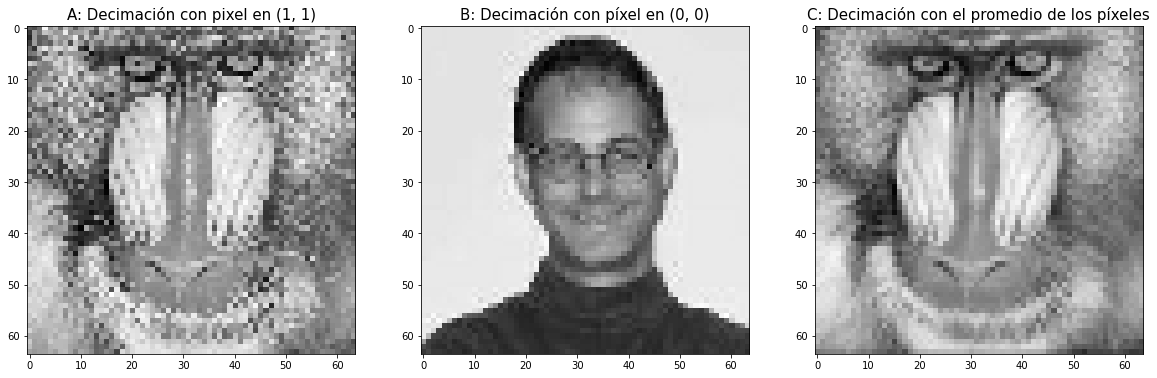

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image_a, cmap='gray')
ax[0].set_title('A: Decimación con pixel en (1, 1)', fontsize=15)
ax[1].imshow(image_b, cmap='gray')
ax[1].set_title('B: Decimación con píxel en (0, 0)', fontsize=15)
ax[2].imshow(image_c, cmap='gray')
ax[2].set_title('C: Decimación con el promedio de los píxeles', fontsize=15)
plt.show()

## Interpolación bilineal
La interpolación bilineal consiste en encontrar el valor de los píxeles agregados por el proceso de upsampling en una imagen, utilizando los cuatro píxeles conocidos más cercanos que lo rodean. Los píxeles conocidos se emplean realizando una interpolación lineal en dos pasos, primero en el eje de coordenadas x y luego en el eje de coordenadas y. Para ello, se transforman las coordenadas según se muestra en la siguiente ilustración,

![bilineal](../resources/imagen_ex_05_a.png)

Así, el interpolador se puede pensar como un campo escalar que determina el valor del píxel de acuerdo a la ubicación a interpolar, según se muestra en la siguiente expresión,

$$f(x,y)=f(0,0) \cdot (1-x) \cdot (1-y) + f(1,0) \cdot x \cdot (1-y) + f(0,1) \cdot (1-x) \cdot y + f(1,1) \cdot x \cdot y$$

Escrito matricialmente, se obtiene que,

$$f(x,y) = X \cdot F \cdot Y = \begin{pmatrix} 1-x & x \end{pmatrix} \cdot \begin{pmatrix} f(0,0) & f(0,1) \\ f(1,0) &  f(1,1) \end{pmatrix} \cdot \begin{pmatrix} 1-y \\ y \end{pmatrix} $$

In [64]:
def bilinear_interpolator(image, ratio):
    """ Upsamples an image applying the bilinear interpolation.
        @param image Original image
        @param ratio Upsampling factor
        @return Interpolated image
    """
    # Fetch the original shape and create the new shape
    input_x, input_y = image.shape
    output_x = int(input_x * ratio)
    output_y = int(input_y * ratio)
    # Create the new image with zeros
    output_image = np.zeros((output_x, output_y))
    for i in range(output_x):
        for j in range(output_y):
            # Coordinates measured from the original image
            aux_x = i / ratio
            aux_y = j / ratio
            # Search for the 4 points used for the interpolation
            x1 = int(aux_x)
            y1 = int(aux_y)
            x2 = x1
            y2 = y1 + 1
            x3 = x1 + 1
            y3 = y1
            x4 = x1 + 1
            y4 = y1 + 1
            x = aux_x - int(aux_x)
            y = aux_y - int(aux_y)
            # When the iteration is already in the limit of the image
            if x4 >= input_x:
                x4 = input_x - 1
                x3 = x4
                x2 = x4 - 1
                x1 = x2
            if y4 >= input_y:
                y4 = input_y - 1
                y3 = y4
                y2 = y4 - 1
                y1 = y2
            # Formula for bilinear interpolation
            X = np.array([[1-x, x]])
            F = np.array([[image[x1, y1], image[x2, y2]], [image[x3, y3], image[x4, y4]]])
            Y = np.array([[1-y, y]]).T
            output_image[i, j] = X @ F @ Y
    return output_image

In [65]:
image_a_bilinear = bilinear_interpolator(image_a, 4)

In [66]:
image_b_bilinear = bilinear_interpolator(image_b, 4)

In [67]:
image_c_bilinear = bilinear_interpolator(image_c, 4)

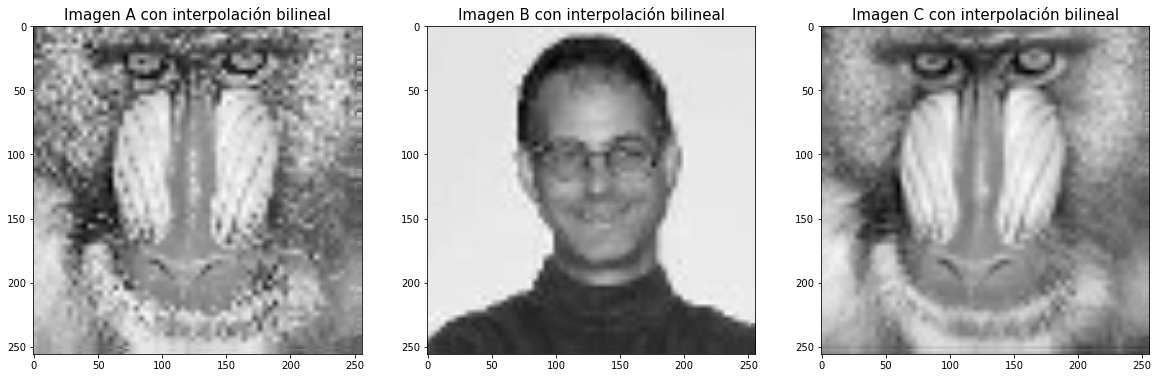

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image_a_bilinear, cmap='gray')
ax[0].set_title('Imagen A con interpolación bilineal', fontsize=15)
ax[1].imshow(image_b_bilinear, cmap='gray')
ax[1].set_title('Imagen B con interpolación bilineal', fontsize=15)
ax[2].imshow(image_c_bilinear, cmap='gray')
ax[2].set_title('Imagen C con interpolación bilineal', fontsize=15)
plt.show()

## Espectro de interpolaciones bilineales
Se calcula la transformada rápida de fourier para las imágenes resultantes de la interpolación bilineal.

In [69]:
spectrum_bilinear_a = np.fft.fftshift(np.fft.fft2(image_a_bilinear, s=(256, 256)))

In [70]:
spectrum_bilinear_b = np.fft.fftshift(np.fft.fft2(image_b_bilinear, s=(256, 256)))

In [71]:
spectrum_bilinear_c = np.fft.fftshift(np.fft.fft2(image_c_bilinear, s=(256, 256)))

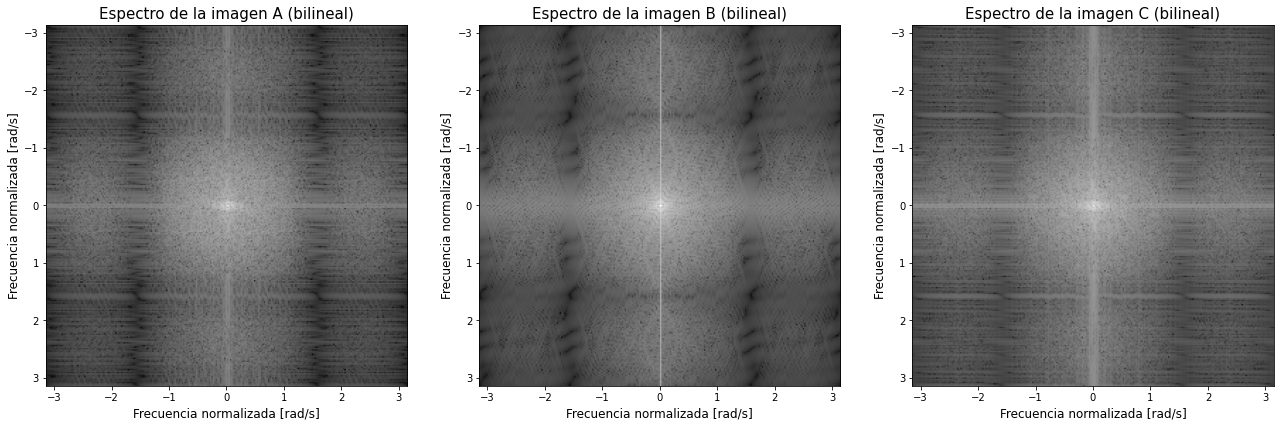

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(22, 15))
ax[0].set_title('Espectro de la imagen A (bilineal)', fontsize=15)
ax[0].imshow(np.log10(np.abs(spectrum_bilinear_a)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[0].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[0].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[1].set_title('Espectro de la imagen B (bilineal)', fontsize=15)
ax[1].imshow(np.log10(np.abs(spectrum_bilinear_b)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[1].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[1].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[2].set_title('Espectro de la imagen C (bilineal)', fontsize=15)
ax[2].imshow(np.log10(np.abs(spectrum_bilinear_c)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[2].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[2].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
plt.show()

## Interpolación bicúbica

A diferencia de la bilineal, la interpolación bicúbica ofrece en general mejores resultados debido a que tiene en cuenta una mayor cantidad de datos; en particular, utiliza los 16 puntos más cercanos para estimar el valor del punto a interpolar. El método elegido para para realizarla es mediante un kernel definido por la siguiente función:


<center><img src="../resources/bicubic_kernel.png"></center>


En el cual $ x $ es una distancia desde el punto a interpolar, con alguno de los 16 puntos de referencia, y $ a $ es un parámetro de ajuste del kernel, definido por el usuario.

Las distancias en $x$ e $y$ son utilizadas para calcular, mediante la función del kernel, los valores que multiplicaran matricialmente a las intensidades de los 16 pixeles más cercanos, como se muestra a continuación:

<center><img src="../resources/bicubic_product.png"></center>

In [73]:
def k(x):
    """ Computes the kernel operation for an input x which is the distance from the interpolation point to the reference point.
        @param x    Distance from the interpolation point to the reference point.
        @return     Result of the computation of the kernel operation.
    """
    a = -0.75
    ret = 0
    absx = abs(x)

    if absx <= 1:
        ret = (a+2)*absx**3 - (a+3)*absx**2 + 1
    elif absx < 2:
        ret = a*absx**3 - 5*a*absx**2 + 8*a*absx - 4*a
        
    return ret


def padding(img, H, W):
    """ Adds 2 rows and 2 cols to each side of the image with the same values as the edges, for the kernel computations to be possible.
        @param img  Original image.
        @param H    Height of the original image.
        @param W    Width of the original image.
        @return     Padded image.
    """
    p_img = np.zeros((H+4, W+4))
    p_img[2:H+2, 2:W+2] = img
      
    # Pad the first/last two col and row
    p_img[2:H+2, 0:2] = img[:, 0:1]
    p_img[2:H+2, W+2:W+4] = img[:, W-1:W]
    p_img[H+2:H+4, 2:W+2] = img[H-1:H, :]
    p_img[0:2, 2:W+2] = img[0:1, :]
      
    # Pad the missing sixteen points
    p_img[0:2, 0:2] = img[0, 0]
    p_img[0:2, W+2:W+4] = img[0, W-1]
    p_img[H+2:H+4, 0:2] = img[H-1, 0]
    p_img[H+2:H+4, W+2:W+4] = img[H-1, W-1]
      
    return p_img


def bicubic_interpolator(image, ratio):
    """ Upsamples an image applying the bicubic interpolation.
        @param image Original image
        @param ratio Upsampling factor
        @return Interpolated image
    """
    # Getting image size
    H, W = image.shape

    # Padding image
    img = padding(image, H, W)
  
    # Getting size for new image
    dH = math.floor(H*ratio)
    dW = math.floor(W*ratio)
  
    # Creating new image
    dst = np.zeros((dH, dW))
  
    h = 1/ratio
  
    for j in range(dH):
        for i in range(dW):
            x, y = i * h + 2, j * h + 2

            dx1 = 1 + x - math.floor(x)
            dx2 = x - math.floor(x)
            dx3 = math.floor(x) + 1 - x
            dx4 = math.floor(x) + 2 - x

            dy1 = 1 + y - math.floor(y)
            dy2 = y - math.floor(y)
            dy3 = math.floor(y) + 1 - y
            dy4 = math.floor(y) + 2 - y

            x_vect = np.matrix([[k(dx1), k(dx2), k(dx3), k(dx4)]])
            points_mat = np.matrix([[img[int(y-dy1), int(x-dx1)],
                                img[int(y-dy2), int(x-dx1)],
                                img[int(y+dy3), int(x-dx1)],
                                img[int(y+dy4), int(x-dx1)]],
                               [img[int(y-dy1), int(x-dx2)],
                                img[int(y-dy2), int(x-dx2)],
                                img[int(y+dy3), int(x-dx2)],
                                img[int(y+dy4), int(x-dx2)]],
                               [img[int(y-dy1), int(x+dx3)],
                                img[int(y-dy2), int(x+dx3)],
                                img[int(y+dy3), int(x+dx3)],
                                img[int(y+dy4), int(x+dx3)]],
                               [img[int(y-dy1), int(x+dx4)],
                                img[int(y-dy2), int(x+dx4)],
                                img[int(y+dy3), int(x+dx4)],
                                img[int(y+dy4), int(x+dx4)]]])
            y_vect = np.matrix(
                [[k(dy1)], [k(dy2)], [k(dy3)], [k(dy4)]])

            # Computing each value of the interpolated image as two dot matix products between 
            # the kernelised x and y vectors, and the reference 16 points
            dst[j, i] = np.dot(np.dot(x_vect, points_mat), y_vect)
  
    return dst

In [74]:
image_a_bicubic = bicubic_interpolator(image_a, 4)

In [75]:
image_b_bicubic = bicubic_interpolator(image_b, 4)

In [76]:
image_c_bicubic = bicubic_interpolator(image_c, 4)

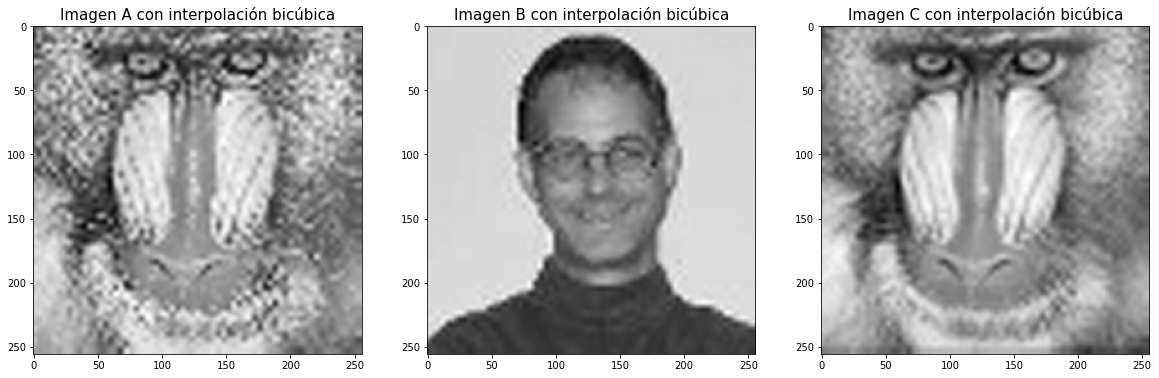

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image_a_bicubic, cmap='gray')
ax[0].set_title('Imagen A con interpolación bicúbica', fontsize=15)
ax[1].imshow(image_b_bicubic, cmap='gray')
ax[1].set_title('Imagen B con interpolación bicúbica', fontsize=15)
ax[2].imshow(image_c_bicubic, cmap='gray')
ax[2].set_title('Imagen C con interpolación bicúbica', fontsize=15)
plt.show()

## Espectro de interpolaciones bicúbicas
Se calcula la transformada rápida de fourier para las imágenes resultantes de la interpolación bicúbica.

In [78]:
spectrum_bicubic_a = np.fft.fftshift(np.fft.fft2(image_a_bicubic, s=(256, 256)))

In [79]:
spectrum_bicubic_b = np.fft.fftshift(np.fft.fft2(image_b_bicubic, s=(256, 256)))

In [80]:
spectrum_bicubic_c = np.fft.fftshift(np.fft.fft2(image_c_bicubic, s=(256, 256)))

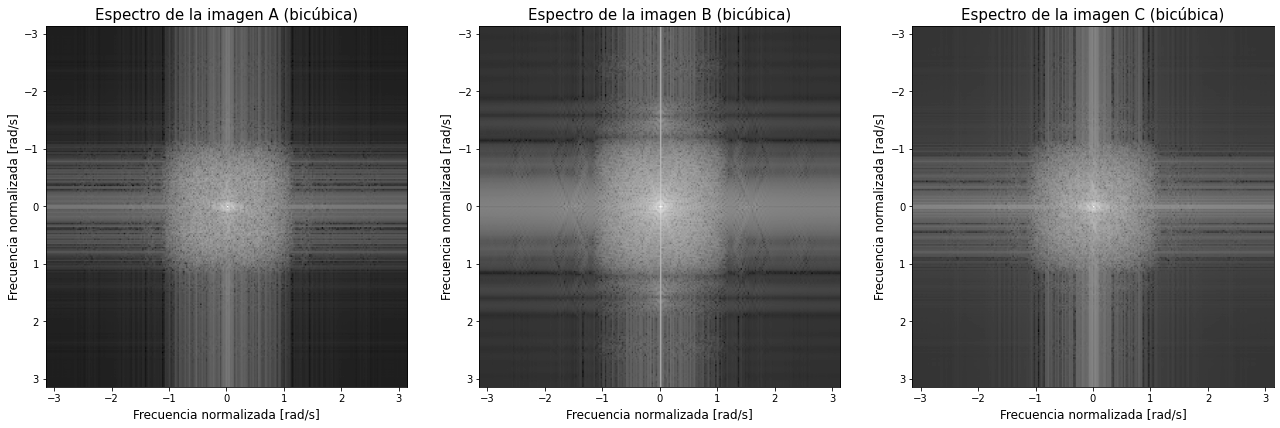

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(22, 15))
ax[0].set_title('Espectro de la imagen A (bicúbica)', fontsize=15)
ax[0].imshow(np.log10(np.abs(spectrum_bicubic_a)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[0].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[0].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[1].set_title('Espectro de la imagen B (bicúbica)', fontsize=15)
ax[1].imshow(np.log10(np.abs(spectrum_bicubic_b)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[1].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[1].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[2].set_title('Espectro de la imagen C (bicúbica)', fontsize=15)
ax[2].imshow(np.log10(np.abs(spectrum_bicubic_c)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[2].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[2].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
plt.show()

## Comparación con OpenCV
En esta sección, se realiza la interpolación bicúbica utilizando el algoritmo provisto por la biblioteca OpenCV, para validar el funcionamiento de la interpolación bicúbica desarrollada.

Si bien no hay demasiado para validar con las imágenes interpoladas con el algoritmo bicúbico desarrollado en este trabajo, y aquel proporcionado por OpenCV, los espectro sirven aquí como herramienta adicional. En las imágenes originales, sencillamente se puede observar que ambos algorítmos funcionan, y que producen resultados cualitativamente muy similares. Sin embargo, la comparación favorable de los espectros logrados (aún cuando en ellos sí se pueden notar las pequeñas diferencias), proporciona más información respecto de la similitud de los resultados obtenidos por ambos algorítmos. 

In [82]:
import cv2

In [83]:
image_a_cv = cv2.resize(image_a.astype('float32'), original_image.shape, interpolation=cv2.INTER_CUBIC)
image_b_cv = cv2.resize(image_b.astype('float32'), original_image.shape, interpolation=cv2.INTER_CUBIC)
image_c_cv = cv2.resize(image_c.astype('float32'), original_image.shape, interpolation=cv2.INTER_CUBIC)

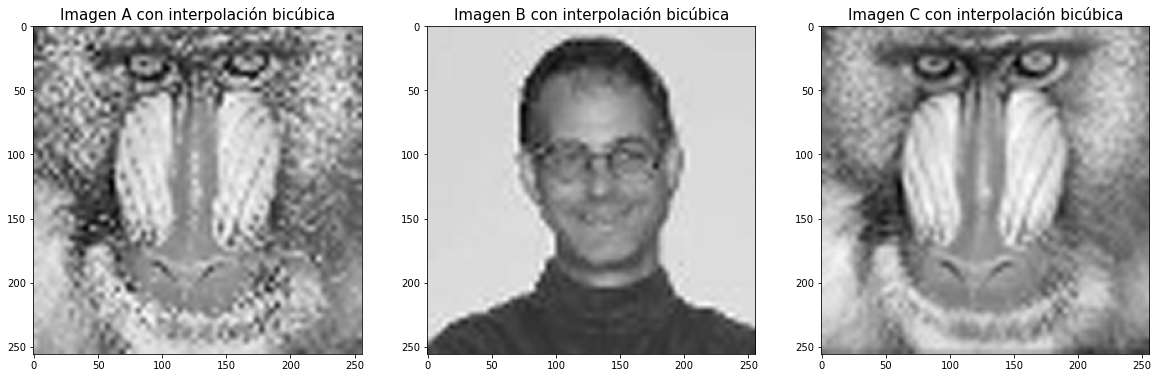

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image_a_cv, cmap='gray')
ax[0].set_title('Imagen A con interpolación bicúbica', fontsize=15)
ax[1].imshow(image_b_cv, cmap='gray')
ax[1].set_title('Imagen B con interpolación bicúbica', fontsize=15)
ax[2].imshow(image_c_cv, cmap='gray')
ax[2].set_title('Imagen C con interpolación bicúbica', fontsize=15)
plt.show()

In [85]:
spectrum_cv_a = np.fft.fftshift(np.fft.fft2(image_a_cv, s=(256, 256)))
spectrum_cv_b = np.fft.fftshift(np.fft.fft2(image_b_cv, s=(256, 256)))
spectrum_cv_c = np.fft.fftshift(np.fft.fft2(image_c_cv, s=(256, 256)))

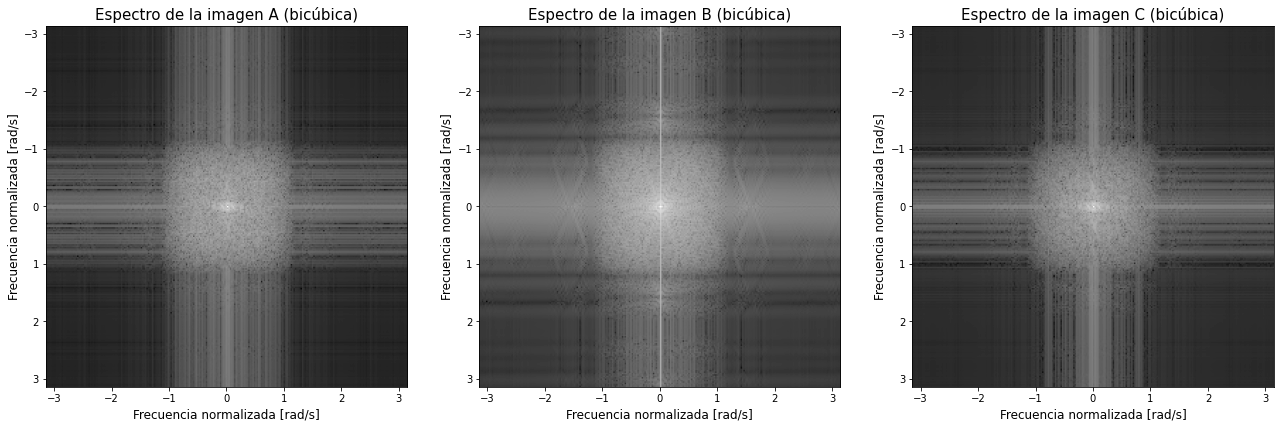

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(22, 15))
ax[0].set_title('Espectro de la imagen A (bicúbica)', fontsize=15)
ax[0].imshow(np.log10(np.abs(spectrum_cv_a)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[0].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[0].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[1].set_title('Espectro de la imagen B (bicúbica)', fontsize=15)
ax[1].imshow(np.log10(np.abs(spectrum_cv_b)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[1].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[1].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[2].set_title('Espectro de la imagen C (bicúbica)', fontsize=15)
ax[2].imshow(np.log10(np.abs(spectrum_cv_c)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[2].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[2].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
plt.show()

## Conclusiones

### Interpretación del espectro de la imagen original
Cuando se observa el espectro de la imagen original, se observan puntos brillantes ubicados a intervalos regulares, y podrían ser pensados como el equivalente a una delta de dirac en esa frecuencia, aunque por estar aplicando la FFT de una ventana espacial de muestras realmente no se observa la delta. Este resultado es razonable si se observa de cerca la imagen, y se ve que existe un patrón periódico con un período espacial de $T = 4 px$, es decir, una frecuencia espacial de $f = \frac{\pi}{2} \approx 1,57$. Justamente, al tener un patrón periódico con este período y frecuencia en ambas direcciones de la imagen, el resultado es una delta desde ambas orientaciones y provoca un punto brillante en el espectro. Más aún, al ser una forma periódica no senoidal ni cosenoidal, se descompone en una serie de frecuencias armónicas que son las que vemos a intervalos regulares (múltiples de la fundamental). 

La razón de ser de este patrón, es justamente el hecho de que dentro de un bloque de 4 píxeles por 4 píxeles, el pixel ubicado en la posición (0,0) pertenece a una imagen diferente que se encuentra escondida dentro de la del mono.

Vale aclarar, que en verdad no es una señal completamente periódica, de hecho en cada repetición del patrón los valores de los píxeles cambian dado el contenido de la imagen del mono y la imagen oculta, no obstante si bien la información del período es diferente, sí hay periodicidad en el patrón con el cual se encuentran. Un análogo con señales temporales sería el multiplexado temporal aplicado en sistemas de comunicaciones para transmitir múltiples canales por un mismo medio, alternando intervalos temporales asignados a cada canal.

![title](../resources/image_ex_05_b.png)

### Comparación de las interpolaciones bilineal y bicúbica
Si se comparan las imagenes obtenidas a partir de interpolación bilineal y bicúbica, a primera vista no se puede percibir una diferencia, no obstante, cuando se comparan los espectros sí se puede evidenciar una notable diferencia entre las imágenes. La interpolación bicúbica obtuvo una imagen resultante cuyo espectro está acotado o limitado, mientras que con la interpolación bilineal se ve contenido espectral en casi todas las frecuencias. Esto podría ser interpretado de diversas formas. En primer lugar, la interpolación bicúbica permite estimar píxeles intermedios obteniendo cambios más suaves que con la interpolación bilineal, eso provoca que el contenido de alta frecuencia espacial sea menor que en la bilineal. En segundo lugar, se podría pensar que ese contenido adicional de alta frecuencia que posee la interpolación bilineal es ruido que representa la incertidumbre en la estimación de los píxeles intermedios al utilizar la bilineal, es decir, que la bicúbica no los presenta porque es más precisa en su estimación.

Resulta interesante pensar que con respecto a aquello que puede percebir el ser humano, las imágenes no presentan diferencias notables, no obstante la imagen obtenida por interpolación bicúbica presenta un espectro considerablemente menor. A priori, uno no conoce el verdadero espectro de la imagen, ya que tanto con la bilineal como la bicúbica se obtienen estimaciones, pero la bicúbica da un resultado idéntico en lo perceptible, y que desde el enfoque de la teoría de la información es más eficiente.

### Comparación de los espectros de cada imagen
Cuando se comparan las tres imágenes obtenidas, la imagen A, B y C, se observa que la imagen B presenta en su espectro una línea vertical centrada en el origen horizontal con una intensidad mayor que en las demás imágenes. Esta línea representa en la orientación vertical un contenido de bajas frecuencias (por eso el espesor pequeño de la línea) y en la orientación horizontal un contenido de altas frecuencias (por eso la extensión de la línea), y está asociada a los bordes de la imagen. Por ende, tiene sentido que sea más intensa en la imagen B, ya que hay un cambio abrupto en la luminosidad de la imagen en el borde de la persona y el fondo. Mientras que en las demás imagenes los cambios son más suaves, sin tanto contraste.